In [ ]:
%pip -q install numpy pandas scipy joblib h5py cvxpy rpy2 ecos scs osqp

In [ ]:
#Folder/File structure: /content/spotlightmod/... and content/synth/main.py
#Locate folders/files (works whether they’re in /content/... or /content/content/...)
import glob, os, pathlib, sys

#find spotlightmod and synth/main.py anywhere under /content
SPOT_DIRS = [p for p in glob.glob('/content/**/spotlightmod', recursive=True) if os.path.isdir(p)]
MAIN_CANDS = glob.glob('/content/**/synth/main.py', recursive=True)

assert SPOT_DIRS, "Couldn't find a 'spotlightmod' folder under /content. Re-upload it."
assert MAIN_CANDS, "Couldn't find 'synth/main.py' under /content. Re-upload the 'synth' folder."

SPOT_DIR   = SPOT_DIRS[0]
MAIN       = sorted(MAIN_CANDS, key=len)[0]   # shortest path
ROOT       = str(pathlib.Path(SPOT_DIR).parents[0])

print("SPOT_DIR =", SPOT_DIR)
print("MAIN     =", MAIN)
print("ROOT     =", ROOT)

SPOT_DIR = /content/content/spotlightmod
MAIN     = /content/content/synth/main.py
ROOT     = /content/content


In [ ]:
#Make the import path + alias “spotlight -> spotlightmod”
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

import importlib
sys.modules['spotlight'] = importlib.import_module('spotlightmod')
print("Alias ready: import spotlight ->", importlib.import_module('spotlight').__name__)

Alias ready: import spotlight -> spotlightmod


In [ ]:
#(Optional) small shim file so relative imports also work
import textwrap, pathlib
shim_dir = pathlib.Path("/content/spotlight")
shim_dir.mkdir(parents=True, exist_ok=True)
(shim_dir / "__init__.py").write_text(textwrap.dedent("""
    import importlib, sys
    sys.modules[__name__] = importlib.import_module('spotlightmod')
"""))
print("Shim at /content/spotlight/__init__.py")

Shim at /content/spotlight/__init__.py


In [ ]:
#import check
import spotlight
import spotlight.datasets.movielens as ml
import spotlight.factorization.explicit as explicit
import spotlight.evaluation as evaluation
print("Imports OK:", spotlight.__name__, ml.__name__, explicit.__name__, evaluation.__name__)

Imports OK: spotlightmod spotlight.datasets.movielens spotlight.factorization.explicit spotlight.evaluation


In [ ]:
#MovieLens-100K download (needed for ml-100k-sample)
!wget -q http://files.grouplens.org/datasets/movielens/ml-100k.zip -O /content/ml-100k.zip
!unzip -q -o /content/ml-100k.zip -d /content
!ls -l /content/ml-100k | head


total 15776
-rwxr-x--- 1 root root     716 Jul 19  2000 allbut.pl
-rwxr-x--- 1 root root     643 Jul 19  2000 mku.sh
-rw-r----- 1 root root    6750 Jan 29  2016 README
-rw-r----- 1 root root 1586544 Mar  8  2001 u1.base
-rw-r----- 1 root root  392629 Mar  8  2001 u1.test
-rw-r----- 1 root root 1583948 Mar  8  2001 u2.base
-rw-r----- 1 root root  395225 Mar  8  2001 u2.test
-rw-r----- 1 root root 1582546 Mar  8  2001 u3.base
-rw-r----- 1 root root  396627 Mar  8  2001 u3.test


In [ ]:
#Build /content/Mlens_100K.joblib in the format example.py expects
import os, joblib, pathlib
from spotlight.datasets.movielens import get_movielens_dataset

#optional: ensure downloads go inside /content (some forks download automatically)
os.environ.setdefault("HOME", "/content")  # many libs cache under $HOME
cache_dir = pathlib.Path("/content/.cache/spotlight"); cache_dir.mkdir(parents=True, exist_ok=True)
os.environ.setdefault("SPOTLIGHT_CACHE_DIR", str(cache_dir))  # if your fork honors it

#movielens.py wants a VARIANT, not a path
ds = get_movielens_dataset("100K")   # <- key change: use a variant string

#Some forks return a single Interactions object; others return (train, test)
if isinstance(ds, (list, tuple)) and len(ds) == 2:
    to_dump = {"train": ds[0], "test": ds[1]}
else:
    to_dump = ds

joblib.dump(to_dump, "/content/Mlens_100K.joblib")
print("Wrote /content/Mlens_100K.joblib")


Wrote /content/Mlens_100K.joblib


In [ ]:
#NOTE: Right now this cell is having errors
#(Optional) Run example.py (auto-found), forcing the child process to see spotlightmod + shim
import os, glob, textwrap, pathlib
EXAMPLE = glob.glob(os.path.join(SPOT_DIR, "example.py"))

if EXAMPLE:
    EXE = EXAMPLE[0]
    print("Running example:", EXE)

    launcher = "/content/run_example.py"
    pathlib.Path(launcher).write_text(textwrap.dedent(f"""
    import sys, importlib, runpy
    sys.path.insert(0, {ROOT!r})           # parent of spotlightmod
    sys.modules['spotlight'] = importlib.import_module('spotlightmod')  # alias spotlight -> spotlightmod
    runpy.run_path({EXE!r}, run_name="__main__")
    """))

    %cd /content
    # Add both /content (shim) and ROOT (spotlightmod parent) to PYTHONPATH
    !PYTHONPATH=/content:{ROOT} python /content/run_example.py
else:
    print("No example.py found in", SPOT_DIR, "— skipping.")


Running example: /content/content/spotlightmod/example.py
/content
Traceback (most recent call last):
  File "/content/run_example.py", line 5, in <module>
    runpy.run_path('/content/content/spotlightmod/example.py', run_name="__main__")
  File "<frozen runpy>", line 287, in run_path
  File "<frozen runpy>", line 98, in _run_module_code
  File "<frozen runpy>", line 88, in _run_code
  File "/content/content/spotlightmod/example.py", line 40, in <module>
    train, test = random_train_test_split(dataset_100k, p=0.2)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: random_train_test_split() got an unexpected keyword argument 'p'


In [ ]:
#Helper: runner
import subprocess, pathlib, shlex, datetime

LOG_DIR = pathlib.Path("/content/run_logs"); LOG_DIR.mkdir(exist_ok=True)

def run_and_log(cmd_list, name=None):
    ts  = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log = LOG_DIR / (name or f"run-{ts}.log")
    print("RUN:", " ".join(shlex.quote(x) for x in cmd_list))
    with log.open("w") as f:
        p = subprocess.Popen(cmd_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        for line in p.stdout:
            print(line, end=""); f.write(line)
        p.wait()
    print(f"[saved -> {log}]\n")
    return str(log)


In [ ]:
#Detect GPU/optimizer flags main.py supports (going to use them automatically)
import torch, subprocess, os
help_txt = subprocess.run(["python", MAIN, "-h"], capture_output=True, text=True).stdout

#device flag
EXTRA_GPU = ["--cuda"] if "--cuda" in help_txt else (["--device","cuda"] if "--device" in help_txt else [])
print("GPU flag(s):", EXTRA_GPU or "(none)")
print("torch.cuda.is_available():", torch.cuda.is_available())
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#optimizer flag - map to the capitalized names expected by main.py
def opt_flag(name: str):
    #normalize input then capitalize for argparse choices
    mapping = {"gd": "GD", "adam": "Adam"}
    chosen = mapping.get(name.lower(), name)
    if "--optim" in help_txt:
        return ["--optim", chosen]
    if "--optimizer" in help_txt:
        return ["--optimizer", chosen]
    return []  #if main.py hardcodes the optimizer



#commonly used train flags (use only if your -h shows them)
HAS_LR        = "--lr"        in help_txt
HAS_SEED      = "--seed"      in help_txt
HAS_INITSCALE = "--initscale" in help_txt

#quick check: should print ... --optim GD ...
print("CMD:", " ".join(
    ["python", MAIN, "--method","DLNN","--data","gaussian","--depth","2","--niters","10"]
    + opt_flag("gd")
))

GPU flag(s): (none)
torch.cuda.is_available(): True
CMD: python /content/content/synth/main.py --method DLNN --data gaussian --depth 2 --niters 10 --optim GD


In [ ]:
#Figure 1 & 2 (Gaussian): GD vs Adam; λ=0 and λ=1e-3; depths 2–5
#(N=100, rank=5; Adam 30k steps; GD 200k steps for speed; one LR if exposed)
depths = ["2","3","4","5"]
N_ITERS_GD   = "200000"   #faster but still shows the same behavior as the 8e5 plot
N_ITERS_ADAM = "30000"

def base_args(depth, lam, opt):
    args = [
        "python", MAIN,
        "--method", "DLNN",
        "--data", "gaussian",
        "--N", "100", "--rank", "5",
        "--depth", depth,
        "--niters", N_ITERS_GD if opt=="gd" else N_ITERS_ADAM,
        "--reg_norm", "ratio", "--lam", lam,
        "--log_interval", "500",
        *EXTRA_GPU, *opt_flag("gd" if opt=="gd" else "adam")
    ]
    if HAS_LR:        args += ["--lr", "1e-3"]
    if HAS_SEED:      args += ["--seed", "0"]
    if HAS_INITSCALE: args += ["--initscale", "1e-3"]
    return args

#Fig.1 (λ=0) #SELF-NOTE - I completed this loop in another session and need to combine my results
for opt in ["gd","adam"]:
    for d in depths:
        run_and_log(base_args(d, "0.0", opt), name=f"F1_{opt}_gauss_d{d}_lam0.log")

#Fig.2 (λ=1e-3)
for opt in ["gd","adam"]:
    for d in depths:
        run_and_log(base_args(d, "1e-3", opt), name=f"F2_{opt}_gauss_d{d}_lam1e-3.log")


RUN: python /content/content/synth/main.py --method DLNN --data gaussian --N 100 --rank 5 --depth 2 --niters 200000 --reg_norm ratio --lam 1e-3 --log_interval 500 --optim GD --lr 1e-3 --initscale 1e-3
depth: 2, iteration: 0, test_RMSE: 1.1215388774871826, erank: 66.70346069335938
depth: 2, iteration: 500, test_RMSE: 1.121538758277893, erank: 63.255130767822266
depth: 2, iteration: 1000, test_RMSE: 1.121538758277893, erank: 59.52436447143555
depth: 2, iteration: 1500, test_RMSE: 1.121538758277893, erank: 55.58884048461914
depth: 2, iteration: 2000, test_RMSE: 1.121538758277893, erank: 51.653141021728516
depth: 2, iteration: 2500, test_RMSE: 1.121538758277893, erank: 47.901851654052734
depth: 2, iteration: 3000, test_RMSE: 1.121538758277893, erank: 44.36375045776367
depth: 2, iteration: 3500, test_RMSE: 1.121538758277893, erank: 40.96484375
depth: 2, iteration: 4000, test_RMSE: 1.121538758277893, erank: 37.734947204589844
depth: 2, iteration: 4500, test_RMSE: 1.121538758277893, erank: 34

In [ ]:
#Figure 3 (Gaussian): depth=1; GD vs Adam; λ=0 and λ=1e-3
def depth1_args(lam, opt):
    args = [
        "python", MAIN,
        "--method", "DLNN", "--data", "gaussian",
        "--N", "100", "--rank", "5",
        "--depth", "1",
        "--niters", N_ITERS_GD if opt=="gd" else N_ITERS_ADAM,
        "--reg_norm", "ratio", "--lam", lam,
        "--log_interval", "500",
        *EXTRA_GPU, *opt_flag("gd" if opt=="gd" else "adam")
    ]
    if HAS_LR:        args += ["--lr", "1e-3"]
    if HAS_SEED:      args += ["--seed", "0"]
    if HAS_INITSCALE: args += ["--initscale", "1e-3"]
    return args

for opt in ["gd","adam"]:
    for lam in ["0.0","1e-3"]:
        run_and_log(depth1_args(lam, opt), name=f"F3_{opt}_gauss_d1_lam{lam}.log")


RUN: python /content/content/synth/main.py --method DLNN --data gaussian --N 100 --rank 5 --depth 1 --niters 200000 --reg_norm ratio --lam 0.0 --log_interval 500 --optim GD --lr 1e-3 --initscale 1e-3
depth: 1, iteration: 0, test_RMSE: 1.1294320821762085, erank: 80.64805603027344
depth: 1, iteration: 500, test_RMSE: 1.1294320821762085, erank: 72.98629760742188
depth: 1, iteration: 1000, test_RMSE: 1.1294320821762085, erank: 70.02960205078125
depth: 1, iteration: 1500, test_RMSE: 1.1294320821762085, erank: 69.3262710571289
depth: 1, iteration: 2000, test_RMSE: 1.1294320821762085, erank: 69.01642608642578
depth: 1, iteration: 2500, test_RMSE: 1.1294320821762085, erank: 68.87308502197266
depth: 1, iteration: 3000, test_RMSE: 1.1294320821762085, erank: 68.79129028320312
depth: 1, iteration: 3500, test_RMSE: 1.1294320821762085, erank: 68.73777770996094
depth: 1, iteration: 4000, test_RMSE: 1.1294320821762085, erank: 68.70069122314453
depth: 1, iteration: 4500, test_RMSE: 1.1294320821762085, 

In [ ]:
#Figure 4 (Gaussian): sample-complexity (small grid to save time)
#Adam+ratio (depth1) vs CP vs SI vs deep GD (depth3, λ=0).
sizes = ["1000","1500","2000","3000","4000"]

#Adam + ratio depth1
for s in sizes:
    run_and_log(["python", MAIN, "--method", "DLNN", "--data", "gaussian",
                 "--N", "100", "--rank", "5", "--depth", "1",
                 "--niters", N_ITERS_ADAM, "--reg_norm", "ratio", "--lam", "1e-3",
                 "--sample_size", s, "--log_interval", "500", *EXTRA_GPU, *opt_flag("adam")],
                name=f"F4_adam_ratio_d1_s{s}.log")

#CP baseline (CPU)
for s in sizes:
    run_and_log(["python", MAIN, "--method", "CP", "--data", "gaussian",
                 "--N", "100", "--rank", "5", "--sample_size", s],
                name=f"F4_CP_s{s}.log")

#SI baseline (CPU)
for s in sizes:
    run_and_log(["python", MAIN, "--method", "SI", "--data", "gaussian",
                 "--N", "100", "--rank", "5", "--sample_size", s],
                name=f"F4_SI_s{s}.log")

#Deep GD depth3 (λ=0)
for s in sizes:
    run_and_log(["python", MAIN, "--method", "DLNN", "--data", "gaussian",
                 "--N", "100", "--rank", "5", "--depth", "3",
                 "--niters", N_ITERS_GD, "--reg_norm", "ratio", "--lam", "0.0",
                 "--sample_size", s, "--log_interval", "1000", *EXTRA_GPU, *opt_flag("gd")],
                name=f"F4_gd_d3_lam0_s{s}.log")


RUN: python /content/content/synth/main.py --method DLNN --data gaussian --N 100 --rank 5 --depth 1 --niters 30000 --reg_norm ratio --lam 1e-3 --sample_size 1000 --log_interval 500 --optim Adam
depth: 1, iteration: 0, test_RMSE: 1.1270689964294434, erank: 80.1642074584961
depth: 1, iteration: 500, test_RMSE: 1.1379179954528809, erank: 54.0785026550293
depth: 1, iteration: 1000, test_RMSE: 1.176574468612671, erank: 40.98146057128906
depth: 1, iteration: 1500, test_RMSE: 1.2404687404632568, erank: 32.143104553222656
depth: 1, iteration: 2000, test_RMSE: 1.3122758865356445, erank: 26.55344009399414
depth: 1, iteration: 2500, test_RMSE: 1.3876078128814697, erank: 22.64537811279297
depth: 1, iteration: 3000, test_RMSE: 1.466212511062622, erank: 19.747760772705078
depth: 1, iteration: 3500, test_RMSE: 1.5484960079193115, erank: 17.51823616027832
depth: 1, iteration: 4000, test_RMSE: 1.6349693536758423, erank: 15.7560453414917
depth: 1, iteration: 4500, test_RMSE: 1.726121425628662, erank: 14

In [ ]:
#MovieLens DLNN (depth-1, λ=0 vs λ=1e-3; Adam budget ~30k)
base_ml = ["python", MAIN, "--method", "DLNN", "--data", "ml-100k-sample",
           "--depth", "1", "--trainprop", "0.8",
           "--reg_norm", "ratio", "--niters", "30000",
           "--log_interval", "500", *EXTRA_GPU]
if HAS_LR:        base_ml += ["--lr", "5e-4"]   #as noted in paper appendix for depth-1 LNN
if HAS_SEED:      base_ml += ["--seed", "0"]
if HAS_INITSCALE: base_ml += ["--initscale", "1e-3"]

run_and_log(base_ml + ["--lam", "0.0"],  name="ML100K_d1_lam0.log")
run_and_log(base_ml + ["--lam", "1e-3"], name="ML100K_d1_lam1e-3.log")


RUN: python /content/content/synth/main.py --method DLNN --data ml-100k-sample --depth 1 --trainprop 0.8 --reg_norm ratio --niters 30000 --log_interval 500 --lr 5e-4 --initscale 1e-3 --lam 0.0
depth: 1, iteration: 0, test_RMSE: 3.718614101409912, erank: 676.2052612304688
depth: 1, iteration: 500, test_RMSE: 3.718614101409912, erank: 626.0317993164062
depth: 1, iteration: 1000, test_RMSE: 3.718614101409912, erank: 625.6163940429688
depth: 1, iteration: 1500, test_RMSE: 3.718614101409912, erank: 625.1592407226562
depth: 1, iteration: 2000, test_RMSE: 3.718614101409912, erank: 624.6503295898438
depth: 1, iteration: 2500, test_RMSE: 3.718614101409912, erank: 624.0858154296875
depth: 1, iteration: 3000, test_RMSE: 3.718614101409912, erank: 623.4701538085938
depth: 1, iteration: 3500, test_RMSE: 3.718614101409912, erank: 622.8220825195312
depth: 1, iteration: 4000, test_RMSE: 3.718614101409912, erank: 622.1642456054688
depth: 1, iteration: 4500, test_RMSE: 3.718614101409912, erank: 621.51403

'/content/run_logs/ML100K_d1_lam1e-3.log'

In [ ]:
#Fix OptSpace/OPT on MovieLens (your IndexError)
#Compute the matrix shape from u.data and pass it so mask is large enough
import pandas as pd, numpy as np

ud = pd.read_csv("/content/ml-100k/u.data", sep="\t", header=None, names=["user","item","rating","ts"])
n_users = int(ud["user"].max())
n_items = int(ud["item"].max())
print("MovieLens dims: users=", n_users, "items=", n_items)

#Try common arg names main.py might accept for dimensions:
DIM_FLAGS = []
if "--m" in help_txt or "--M" in help_txt: DIM_FLAGS += ["--M", str(n_users)]
if "--n" in help_txt or "--N" in help_txt: DIM_FLAGS += ["--N", str(n_items)]
#If it only has a single square --N, use the larger dim
if not DIM_FLAGS and "--N" in help_txt: DIM_FLAGS += ["--N", str(max(n_users, n_items))]

print("Using OPT dimension flags:", DIM_FLAGS or "(none; OPT may only support synthetic)")

run_and_log(["python", MAIN, "--method", "OPT", "--data", "ml-100k-sample",
             "--trainprop", "0.8", *DIM_FLAGS],
            name="ML100K_OPT.log")


MovieLens dims: users= 943 items= 1682
Using OPT dimension flags: ['--M', '943', '--N', '1682']
RUN: python /content/content/synth/main.py --method OPT --data ml-100k-sample --trainprop 0.8 --M 943 --N 1682
usage: main.py [-h] [--method {DLNN,CP,SI,OPT}]
               [--data {gaussian,ml-100k-sample}] [--rank RANK]
               [--depth DEPTH] [--fold FOLD]
               [--optim {Adam,LBFGS,GD,ASGD,Adagrad,RMSprop,Momentum,Adamax,Adam_amsgrad,AdamW,NAdam,RAdam,Adadelta}]
               [--N N] [--sample_size SAMPLE_SIZE] [--test_size TEST_SIZE]
               [--niters NITERS] [--nonlinear]
               [--reg_norm {ratio,nuclear,sc_12,sc_13,sc_23,sc_1223,sc_1323,sc_1312}]
               [--lam LAM] [--initscale INITSCALE]
               [--log_interval LOG_INTERVAL] [--store_sv] [--lrsched LRSCHED]
               [--std {z,minmax,None}] [--incl_bias INCL_BIAS] [--lr LR]
               [--trainprop TRAINPROP]
main.py: error: unrecognized arguments: --M 943
[saved -> /content/ru

'/content/run_logs/ML100K_OPT.log'

In [ ]:
#Summarize results (same as parser/CSV)
import re, pandas as pd, pathlib
rows = []
for p in pathlib.Path("/content/run_logs").glob("*.log"):
    txt = p.read_text(errors="ignore")
    #try to grab a final metric
    m = re.findall(r"(test[_\s-]*rmse|rmse[_\s-]*test|rmse|error|mse)\s*[:=]\s*([0-9eE.+-]+)", txt, flags=re.I)
    metric = float(m[-1][1]) if m else None
    rows.append({"log": p.name, "metric": metric})
df = pd.DataFrame(rows).sort_values("log")
display(df)
out = "/content/run_logs/summary.csv"; df.to_csv(out, index=False); print("Saved:", out)


,log,metric
36,F1_adam_gauss_d2_lam0.log,1.194253
32,F1_adam_gauss_d3_lam0.log,1.355060
13,F1_adam_gauss_d4_lam0.log,1.364235
16,F1_adam_gauss_d5_lam0.log,1.383459
2,F1_gd_gauss_d2_lam0.log,1.125116
27,F1_gd_gauss_d3_lam0.log,1.126264
19,F1_gd_gauss_d4_lam0.log,1.128551
22,F1_gd_gauss_d5_lam0.log,1.119118
15,F2_adam_gauss_d2_lam1e-3.log,1.367607
3,F2_adam_gauss_d3_lam1e-3.log,1.367835


Saved: /content/run_logs/summary.csv


In [ ]:
#robust log parser -> per-iteration dataframe(s)
import re, pathlib, pandas as pd

LOG_DIR = pathlib.Path("/content/run_logs")

#Patterns are intentionally permissive and case-insensitive
P_ITER = re.compile(r"(?:^|\b)(?:it|iter|iteration)\s*[:=]\s*(\d+)", re.I)
P_ERR  = re.compile(r"(?:test[_\s-]*)?(?:rmse|mse|error)\s*[:=]\s*([0-9.eE+\-]+)", re.I)
P_RANK = re.compile(r"(?:effective[_\s-]*rank|eff[_\s-]*rank|rank)\s*[:=]\s*([0-9.eE+\-]+)", re.I)
P_S1   = re.compile(r"(?:s1|sv1|sigma1|singular[_\s-]*1(?:st)?)\s*[:=]\s*([0-9.eE+\-]+)", re.I)
P_S5   = re.compile(r"(?:s5|sv5|sigma5|singular[_\s-]*5(?:th)?)\s*[:=]\s*([0-9.eE+\-]+)", re.I)

def parse_curve(log_path, default_interval=500):
    """Return a DataFrame with columns: iter, error, rank, s1, s5."""
    it_val, last_emitted = None, -1
    rows = []
    for line in open(log_path, "r", errors="ignore"):
        m_it = P_ITER.search(line)
        if m_it: it_val = int(m_it.group(1))
        m_err  = P_ERR.search(line)
        m_rank = P_RANK.search(line)
        m_s1   = P_S1.search(line)
        m_s5   = P_S5.search(line)

        have_something = any([m_err, m_rank, m_s1, m_s5])
        if have_something:
            if it_val is None:
                # fallback: synthesize iteration by counting emissions
                it_val = (last_emitted + 1) * default_interval
            rows.append({
                "iter": it_val,
                "error": float(m_err.group(1)) if m_err else None,
                "rank":  float(m_rank.group(1)) if m_rank else None,
                "s1":    float(m_s1.group(1)) if m_s1 else None,
                "s5":    float(m_s5.group(1)) if m_s5 else None,
            })
            last_emitted += 1
    return pd.DataFrame(rows)

def tag_from_name(name):
    """Infer metadata (figure, opt, depth, lam, data) from filename."""
    info = {"fig": None, "opt": None, "depth": None, "lam": None, "data": None}
    low = name.lower()
    if low.startswith("f1_"): info["fig"] = "F1"
    elif low.startswith("f2_"): info["fig"] = "F2"
    elif low.startswith("f3_"): info["fig"] = "F3"
    elif low.startswith("f4_"): info["fig"] = "F4"
    info["opt"]   = "adam" if "adam" in low else ("gd" if "gd" in low else None)
    md = re.search(r"d(?:epth)?(\d+)", low); info["depth"] = int(md.group(1)) if md else None
    ml = re.search(r"lam([0-9eE\.\-\+]+)", low); info["lam"] = ml.group(1) if ml else None
    info["data"]  = "ml-100k" if "ml100k" in low or "ml-100k" in low else ("gaussian" if "gauss" in low else None)
    return info

#Build a dict of {log_name: parsed_df, meta}
parsed = {}
for p in LOG_DIR.glob("*.log"):
    dfc = parse_curve(p)
    if not dfc.empty:
        meta = tag_from_name(p.name)
        parsed[p.name] = {"meta": meta, "df": dfc.sort_values("iter")}
len(parsed), list(parsed.keys())[:6]


(32,
 ['F2_gd_gauss_d5_lam1e-3.log',
  'F1_gd_gauss_d2_lam0.log',
  'F2_adam_gauss_d3_lam1e-3.log',
  'F4_adam_ratio_d1_s4000.log',
  'F4_gd_d3_lam0_s1500.log',
  'F2_adam_gauss_d5_lam1e-3.log'])

In [ ]:
#helper to save the current matplotlib figure
import matplotlib.pyplot as plt, os

def savefig(name, dpi=160):
    path = f"/content/run_logs/{name}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved", path)


/tmp/ipython-input-3784868332.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best"); plt.grid(True, alpha=0.3)


Saved /content/run_logs/fig1_error.png


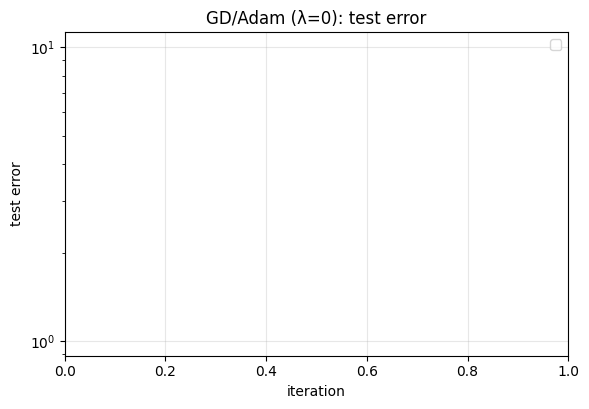

Saved /content/run_logs/fig1_rank.png


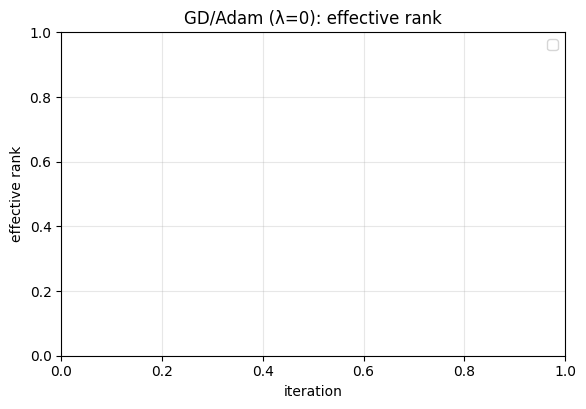

Saved /content/run_logs/fig1_singular.png


/tmp/ipython-input-3784868332.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best"); plt.grid(True, alpha=0.3)


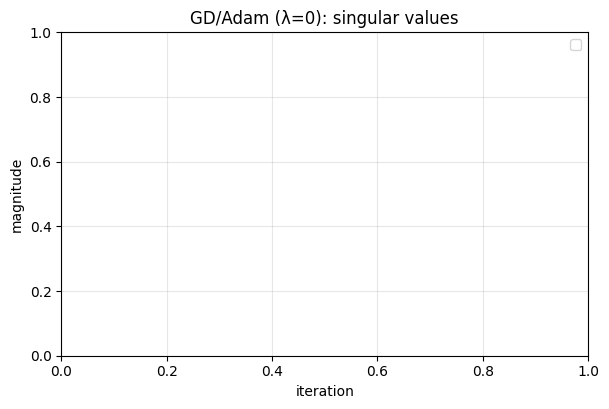

In [ ]:
#Figure 1 style plots (λ=0) + save PNGs
import matplotlib.pyplot as plt

def plot_fig1_component(ykey, ylabel, title, fname):
    plt.figure(figsize=(6.5,4.2))
    for name, obj in parsed.items():
        m = obj["meta"]
        if m["fig"] != "F1":
            continue
        if m["lam"] not in ("0", "0.0"):
            continue
        d = obj["df"]
        y = d[ykey].dropna()
        if y.empty:
            continue
        label = f"{m['opt']}, depth {m['depth']}"
        plt.plot(d["iter"].iloc[:len(y)], y.values, label=label)
    if ykey == "error":
        plt.yscale("log")
    plt.xlabel("iteration"); plt.ylabel(ylabel); plt.title(title)
    plt.legend(loc="best"); plt.grid(True, alpha=0.3)
    savefig(fname); plt.show()

plot_fig1_component("error", "test error", "GD/Adam (λ=0): test error", "fig1_error.png")
plot_fig1_component("rank",  "effective rank", "GD/Adam (λ=0): effective rank", "fig1_rank.png")

#singular values: s1 solid, s5 dashed
plt.figure(figsize=(6.8,4.2))
for name, obj in parsed.items():
    m = obj["meta"]
    if m["fig"] != "F1" or m["lam"] not in ("0","0.0"):
        continue
    d = obj["df"]
    if "s1" in d and d["s1"].notna().any():
        plt.plot(d["iter"], d["s1"], label=f"{m['opt']}, d{m['depth']} s1")
    if "s5" in d and d["s5"].notna().any():
        plt.plot(d["iter"], d["s5"], linestyle="--", label=f"{m['opt']}, d{m['depth']} s5")
plt.xlabel("iteration"); plt.ylabel("magnitude"); plt.title("GD/Adam (λ=0): singular values")
plt.legend(loc="best"); plt.grid(True, alpha=0.3)
savefig("fig1_singular.png"); plt.show()


/tmp/ipython-input-2182550759.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best"); plt.grid(True, alpha=0.3)


Saved /content/run_logs/fig2_error.png


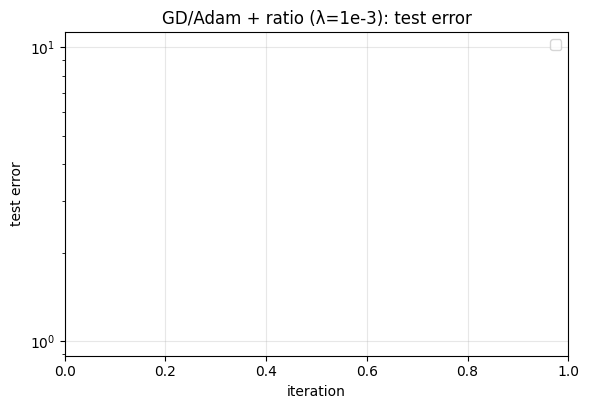

Saved /content/run_logs/fig2_rank.png


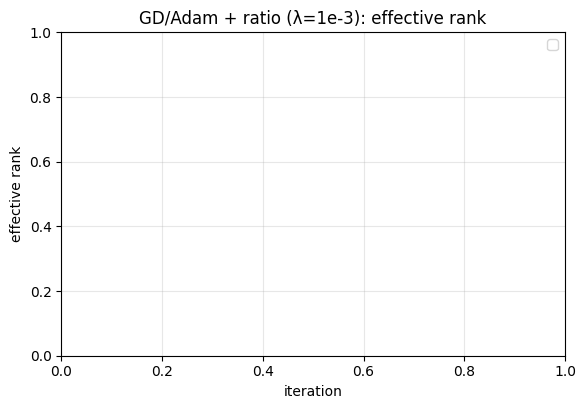

Saved /content/run_logs/fig2_singular.png


/tmp/ipython-input-2182550759.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best"); plt.grid(True, alpha=0.3)


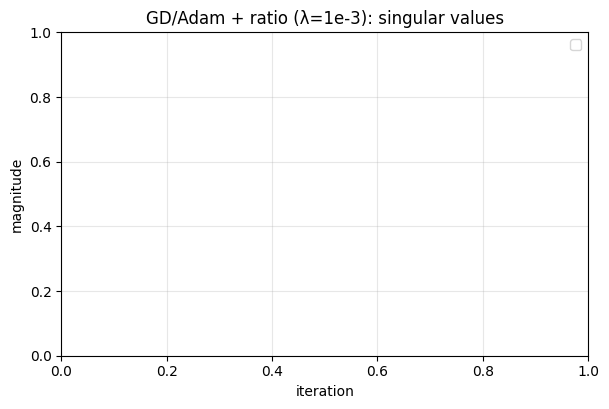

In [ ]:
#Figure 2 style plots (λ=1e-3) + save PNGs
import matplotlib.pyplot as plt

def plot_fig2_component(ykey, ylabel, title, fname):
    plt.figure(figsize=(6.5,4.2))
    for name, obj in parsed.items():
        m = obj["meta"]
        if m["fig"] != "F2" or (m["lam"] not in ("1e-3","0.001")):
            continue
        d = obj["df"]
        y = d[ykey].dropna()
        if y.empty: continue
        label = f"{m['opt']}, depth {m['depth']}"
        plt.plot(d["iter"].iloc[:len(y)], y.values, label=label)
    if ykey == "error":
        plt.yscale("log")
    plt.xlabel("iteration"); plt.ylabel(ylabel); plt.title(title)
    plt.legend(loc="best"); plt.grid(True, alpha=0.3)
    savefig(fname); plt.show()

plot_fig2_component("error", "test error", "GD/Adam + ratio (λ=1e-3): test error", "fig2_error.png")
plot_fig2_component("rank",  "effective rank", "GD/Adam + ratio (λ=1e-3): effective rank", "fig2_rank.png")

#singular values
plt.figure(figsize=(6.8,4.2))
for name, obj in parsed.items():
    m = obj["meta"]
    if m["fig"] != "F2" or (m["lam"] not in ("1e-3","0.001")):
        continue
    d = obj["df"]
    if "s1" in d and d["s1"].notna().any():
        plt.plot(d["iter"], d["s1"], label=f"{m['opt']}, d{m['depth']} s1")
    if "s5" in d and d["s5"].notna().any():
        plt.plot(d["iter"], d["s5"], linestyle="--", label=f"{m['opt']}, d{m['depth']} s5")
plt.xlabel("iteration"); plt.ylabel("magnitude"); plt.title("GD/Adam + ratio (λ=1e-3): singular values")
plt.legend(loc="best"); plt.grid(True, alpha=0.3)
savefig("fig2_singular.png"); plt.show()


Saved /content/run_logs/fig3_error.png


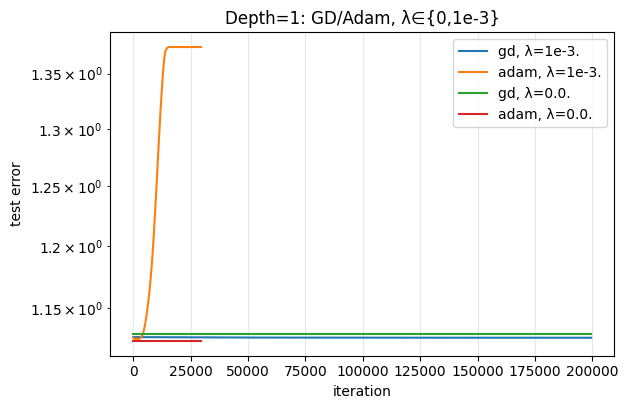

Saved /content/run_logs/fig3_rank.png


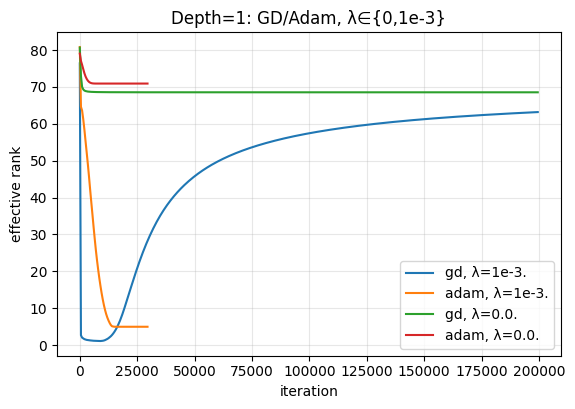

In [ ]:
#Figure 3 (depth=1), save two PNGs
import matplotlib.pyplot as plt

def sel(meta, fig="F3", depth=1, lam=None, opt=None):
    return (meta["fig"]==fig) and (meta["depth"]==depth) and (lam is None or meta["lam"]==lam) and (opt is None or meta["opt"]==opt)

#test error
plt.figure(figsize=(6.5,4.2))
for name, obj in parsed.items():
    m, d = obj["meta"], obj["df"]
    if not sel(m, fig="F3", depth=1):
        continue
    y = d["error"].dropna()
    if y.empty: continue
    lab = f"{m['opt']}, λ={m['lam']}"
    plt.plot(d["iter"].iloc[:len(y)], y.values, label=lab)
plt.yscale("log"); plt.xlabel("iteration"); plt.ylabel("test error")
plt.title("Depth=1: GD/Adam, λ∈{0,1e-3}"); plt.legend(); plt.grid(True, alpha=0.3)
savefig("fig3_error.png"); plt.show()

#effective rank
plt.figure(figsize=(6.5,4.2))
for name, obj in parsed.items():
    m, d = obj["meta"], obj["df"]
    if not sel(m, fig="F3", depth=1):
        continue
    y = d["rank"].dropna()
    if y.empty: continue
    lab = f"{m['opt']}, λ={m['lam']}"
    plt.plot(d["iter"].iloc[:len(y)], y.values, label=lab)
plt.xlabel("iteration"); plt.ylabel("effective rank")
plt.title("Depth=1: GD/Adam, λ∈{0,1e-3}"); plt.legend(); plt.grid(True, alpha=0.3)
savefig("fig3_rank.png"); plt.show()


Saved /content/run_logs/fig4_sample_complexity.png


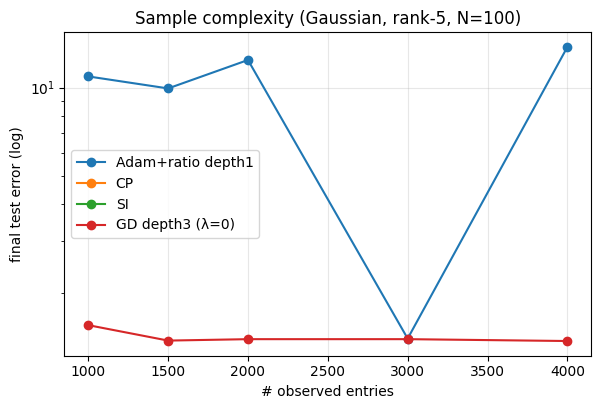

In [ ]:
#Figure 4: sample complexity; save PNG
import re, numpy as np, matplotlib.pyplot as plt, pathlib

def last_metric(path):
    txt = open(path, "r", errors="ignore").read()
    m = re.findall(r"(?:test[_\s-]*rmse|rmse|error|mse)\s*[:=]\s*([0-9eE.+-]+)", txt, flags=re.I)
    return float(m[-1]) if m else np.nan

def collect_by_prefix(prefix):
    pts = []
    for p in pathlib.Path("/content/run_logs").glob(f"{prefix}*.log"):
        m = re.search(r"_s(\d+)\.log$", p.name)
        if not m:
            continue
        s = int(m.group(1))
        val = last_metric(p)
        pts.append((s, val))
    pts.sort()
    return pts

curves = {
    "Adam+ratio depth1": collect_by_prefix("F4_adam_ratio_d1_"),
    "CP":                collect_by_prefix("F4_CP_"),
    "SI":                collect_by_prefix("F4_SI_"),
    "GD depth3 (λ=0)":   collect_by_prefix("F4_gd_d3_lam0_"),
}

plt.figure(figsize=(6.8,4.2))
for label, pts in curves.items():
    if not pts: continue
    xs, ys = zip(*pts)
    plt.plot(xs, ys, marker="o", label=label)
plt.yscale("log")
plt.xlabel("# observed entries"); plt.ylabel("final test error (log)")
plt.title("Sample complexity (Gaussian, rank-5, N=100)")
plt.legend(); plt.grid(True, alpha=0.3)
savefig("fig4_sample_complexity.png"); plt.show()


Saved /content/run_logs/ml100k_bars.png


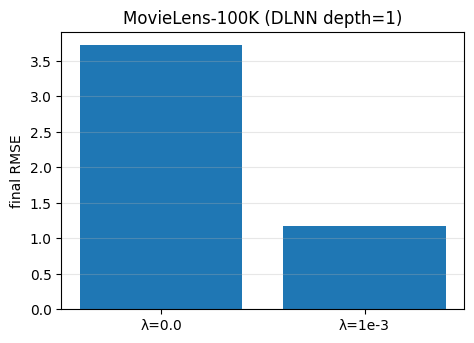

{'λ=0.0': 3.718614101409912, 'λ=1e-3': 1.1665301322937012}


In [ ]:
#MovieLens bars; save PNG
import numpy as np, matplotlib.pyplot as plt, re, pathlib

def final_metric(name):
    p = pathlib.Path("/content/run_logs")/name
    if not p.exists(): return np.nan
    txt = p.read_text(errors="ignore")
    m = re.findall(r"(?:rmse|error|mse)\s*[:=]\s*([0-9eE.+-]+)", txt, flags=re.I)
    return float(m[-1]) if m else np.nan

vals = [
    ("λ=0.0",  final_metric("ML100K_d1_lam0.log")),
    ("λ=1e-3", final_metric("ML100K_d1_lam1e-3.log")),
]
labels, ys = zip(*vals)

plt.figure(figsize=(5.2,3.6))
pos = np.arange(len(labels))
plt.bar(pos, ys)
plt.xticks(pos, labels)
plt.ylabel("final RMSE")
plt.title("MovieLens-100K (DLNN depth=1)")
plt.grid(axis="y", alpha=0.3)
savefig("ml100k_bars.png"); plt.show()

print(dict(vals))
